In [1]:
import os
import sys
sys.path.append("./../")
import numpy as np
import matplotlib.pyplot as plt
import pdb
import pandas as pd
import yaml
import h5py
import vicon_imu_data_process.process_landing_data as pro_rd
#import assessments.scores as es_as

import seaborn as sns
import copy
import re
import json

from vicon_imu_data_process.const import FEATURES_FIELDS, LABELS_FIELDS, DATA_PATH
from vicon_imu_data_process.const import DROPLANDING_PERIOD, RESULTS_PATH
from vicon_imu_data_process import const
from vicon_imu_data_process.dataset import *

from models.rnn_models import *
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
import time as localtimepkg

#from estimation_study import *
from assessments.visualization import *
#import pdb
import re

2023-02-14 06:32:57.621300: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-14 06:32:57.683158: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-14 06:32:57.685307: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.3/lib64:/usr/local/cuda-11.3/lib64
2023-02-14 06:32:57.685318: I tensorflow

tensorflow version: 2.11.0


## Baseline

### Baseline curves

/home/sun/workspace/PythonProject/DataAnalysis/P6/transfer_learning_for_droplanding/assessments/./../../../CRCF/plot_utilities.py:44: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig(figPath)
/home/sun/.pyenv/versions/3.9.2/envs/machinelearning/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


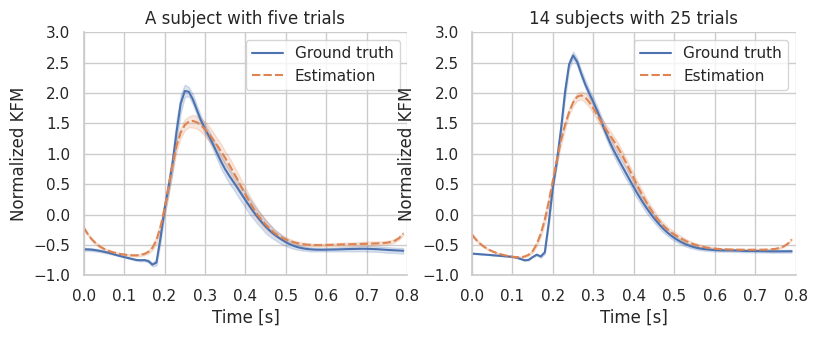

/media/sun/TFcard/drop_landing_workspace/results/training_testing/visualization/P6/Fig_results_baseline_curves.svg


In [9]:
## Plot estimation curves


combination_investigation_results = [
    os.path.join(RESULTS_PATH, "training_testing","baseline_mlnn_v11_5",str(train_sub_num)+"sub",str(trial_num)+"trials","testing_result_folders.txt") for train_sub_num in [1] for trial_num in [5]
                                    ]+[
    os.path.join(RESULTS_PATH, "training_testing","baseline_mlnn_v11_5",str(train_sub_num)+"sub",str(trial_num)+"trials","testing_result_folders.txt") for train_sub_num in [14] for trial_num in [25]]


config = {
  'xticks':[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
  'yticks':[-1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0],
 'ylim':[-1.0, 3.0],
  'figsize': (8,3),
  'ylabels': 5*['Normalized KFM'],
   'titles': ['A subject with five trials', '14 subjects with 25 trials'],
  'font_scale':1.0, 
   'save_fig': True,
    'fig_path': os.path.join(RESULTS_PATH,"training_testing/visualization/P6","Fig_results_baseline_curves.svg"),
    'save_format': '.svg'
}

figpath, multi_model_results = p6plot_statistic_actual_estimation_curves(combination_investigation_results, col_wrap=2, **config)

### baseline heatmap

/media/sun/TFcard/drop_landing_workspace/results/training_testing/baseline_mlnn_v11_5/1sub/5trials/metrics.csv
DROP R2 cases below :0.0
/media/sun/TFcard/drop_landing_workspace/results/training_testing/baseline_mlnn_v11_5/1sub/10trials/metrics.csv
DROP R2 cases below :0.0
/media/sun/TFcard/drop_landing_workspace/results/training_testing/baseline_mlnn_v11_5/1sub/15trials/metrics.csv
DROP R2 cases below :0.0
/media/sun/TFcard/drop_landing_workspace/results/training_testing/baseline_mlnn_v11_5/1sub/20trials/metrics.csv
DROP R2 cases below :0.0
/media/sun/TFcard/drop_landing_workspace/results/training_testing/baseline_mlnn_v11_5/1sub/25trials/metrics.csv
DROP R2 cases below :0.0
/media/sun/TFcard/drop_landing_workspace/results/training_testing/baseline_mlnn_v11_5/2sub/5trials/metrics.csv
DROP R2 cases below :0.0
/media/sun/TFcard/drop_landing_workspace/results/training_testing/baseline_mlnn_v11_5/2sub/10trials/metrics.csv
DROP R2 cases below :0.0
/media/sun/TFcard/drop_landing_workspace/re

/tmp/ipykernel_13933/1231915603.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  data = baseline_metrics[['trial_num','train_sub_num','r2']].groupby(['train_sub_num','trial_num']).mean().round(2).reset_index().pivot('train_sub_num','trial_num')['r2']
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not

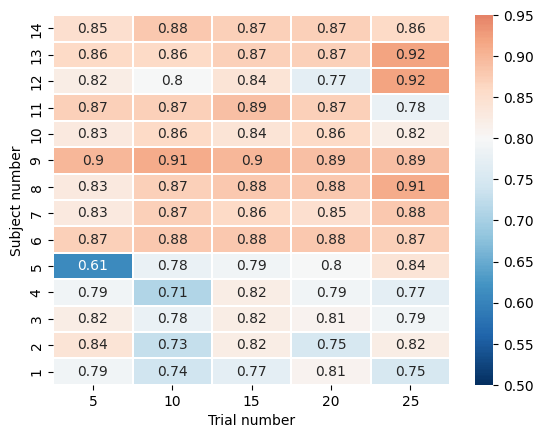

'/media/sun/TFcard/drop_landing_workspace/results/visualization/P6/Fig_results_baseline_heatmap.svg/data_visulization/2023-02-14/03_42_55_results.svg'

In [4]:
# plot heatmap

combination_investigation_results = [
    os.path.join(RESULTS_PATH, "training_testing", "baseline_mlnn_v11_5",
                str(sub_idx)+"sub", str(trial_idx)+"trials", 
                 "testing_result_folders.txt") for sub_idx in range(1,15,1) for trial_idx in range(5, 26,5)]

#metrics = get_list_investigation_metrics(combination_investigation_results)

combination_investigation_metrics = [os.path.join(os.path.dirname(folder), "metrics.csv") for folder in combination_investigation_results]
filters={'drop_value':0.0,'sort_variable':'r2'}

baseline_metrics = parase_list_investigation_metrics(combination_investigation_metrics,calculate_mean_subject_r2=True,**filters)
data = baseline_metrics[['trial_num','train_sub_num','r2']].groupby(['train_sub_num','trial_num']).mean().round(2).reset_index().pivot('train_sub_num','trial_num')['r2']
#data = baseline_metrics[['trial_num','subject_num','mean_subject_r2']].groupby(['subject_num','trial_num']).median().round(2).reset_index().pivot('subject_num','trial_num')['mean_subject_r2']
ax = sns.heatmap(data, vmin=0.5, vmax=0.95,cmap="RdBu_r",center=0.8,annot=True,linewidths=0.3).invert_yaxis()
plt.ylabel('Subject number')
plt.xlabel('Trial number')
save_format='svg'
fig_path=os.path.join(RESULTS_PATH, "visualization/P6/Fig_results_baseline_heatmap.svg")
#fig_path=os.path.join("./","visualization/P6/Fig_results_baseline_heatmap.svg")

save_figure(fig_path,fig_format=save_format)
#save_figure(os.path.dirname(combination_investigation_metrics[0]),fig_format=save_format)


In [6]:
baseline_metrics[(baseline_metrics['train_sub_num']>1)&(baseline_metrics['trial_num']>5)][['train_sub_num','trial_num','test_subject','r2','mean_subject_r2']].groupby(['train_sub_num','trial_num']).median()

/tmp/ipykernel_30033/2457921738.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  baseline_metrics[(baseline_metrics['train_sub_num']>1)&(baseline_metrics['trial_num']>5)][['train_sub_num','trial_num','test_subject','r2','mean_subject_r2']].groupby(['train_sub_num','trial_num']).median()


r2  mean_subject_r2
train_sub_num trial_num                         
2             10         0.8195          0.83400
              15         0.8515          0.85800
              20         0.8295          0.81260
              25         0.8365          0.77680
3             10         0.8550          0.80220
              15         0.8350          0.84410
              20         0.8335          0.83570
              25         0.7925          0.77680
4             10         0.8270          0.84590
              15         0.8555          0.86390
              20         0.8535          0.86770
              25         0.8155          0.78600
5             10         0.7980          0.79290
              15         0.8015          0.80455
              20         0.8030          0.80530
              25         0.8585          0.83010
6             10         0.9050          0.86670
              15         0.9180          0.87970
              20         0.9215          0.87995
              25         0.9020          0.87645
7             10         0.8900          0.84060
              15         0.8750          0.86390
              20         0.8800          0.84880
              25         0.9070          0.92180
8             10         0.8965          0.84260
              15         0.9030          0.85495
              20         0.8985          0.85520
              25         0.9445          0.94670
9             10         0.9280          0.83930
              15         0.9220          0.86980
              20         0.9080          0.86465
              25         0.9060          0.87490
10            10         0.8770          0.83530
              15         0.8700          0.85190
              20         0.8835          0.84880
              25         0.8455          0.83010
11            10         0.9060          0.83465
              15         0.9180          0.85800
              20         0.9060          0.84285
              25         0.8280          0.77680
12            10         0.8715          0.83400
              15         0.8785          0.84475
              20         0.8450          0.81260
              25         0.9290          0.91260
13            10         0.9030          0.83400
              15         0.9000          0.86085
              20         0.8900          0.83630
              25         0.9300          0.91260
14            10         0.9105          0.82180
              15         0.8905          0.84800
              20         0.8955          0.84285
              25         0.8850          0.86500

In [7]:
# table

filters={'drop_value':0.0,'sort_variable':'r2'}
baseline_metrics = parase_list_investigation_metrics(combination_investigation_metrics,**filters)
baseline_metrics[['trial_num','train_sub_num','r2']][aug_metrics['trial_num'].isin([25])].groupby(['train_sub_num','trial_num']).describe().round(2)['r2'][['min','50%', '75%','max']].T

/media/sun/TFcard/drop_landing_workspace/results/training_testing/baseline_mlnn_v11_5/1sub/5trials/metrics.csv
DROP R2 cases below :0.0
/media/sun/TFcard/drop_landing_workspace/results/training_testing/baseline_mlnn_v11_5/1sub/10trials/metrics.csv
DROP R2 cases below :0.0
/media/sun/TFcard/drop_landing_workspace/results/training_testing/baseline_mlnn_v11_5/1sub/15trials/metrics.csv
DROP R2 cases below :0.0
/media/sun/TFcard/drop_landing_workspace/results/training_testing/baseline_mlnn_v11_5/1sub/20trials/metrics.csv
DROP R2 cases below :0.0
/media/sun/TFcard/drop_landing_workspace/results/training_testing/baseline_mlnn_v11_5/1sub/25trials/metrics.csv
DROP R2 cases below :0.0
/media/sun/TFcard/drop_landing_workspace/results/training_testing/baseline_mlnn_v11_5/2sub/5trials/metrics.csv
DROP R2 cases below :0.0
/media/sun/TFcard/drop_landing_workspace/results/training_testing/baseline_mlnn_v11_5/2sub/10trials/metrics.csv
DROP R2 cases below :0.0
/media/sun/TFcard/drop_landing_workspace/re

NameError: name 'aug_metrics' is not defined

In [14]:
combination_investigation_metrics = [os.path.join(os.path.dirname(folder),"metrics.csv") for folder in combination_investigation_results]
filters={'drop_value':0.0,'sort_variable':'r2'}
baseline_metrics = parase_list_investigation_metrics(combination_investigation_metrics,**filters)
baseline_metrics['subject_num'].replace({idx:idx-4 for idx in range(5,11)},inplace=True)

baseline_metrics[['trial_num','subject_num','r2']][baseline_metrics['trial_num'].isin([25])].groupby(['subject_num','trial_num']).describe().round(2)['r2'][['min','50%', '75%','max']].T
#baseline_metrics[['trial_num','subject_num','r2']].groupby(['subject_num','trial_num']).describe().round(2)['r2'][['min','50%', '75%','max']].T

/home/sun/drop_landing_workspace/results/training_testing/investigation_imu_augment_v3/10trials/11sub/metrics.csv
DROP R2 cases below :0.0
/home/sun/drop_landing_workspace/results/training_testing/investigation_imu_augment_v3/10trials/12sub/metrics.csv
DROP R2 cases below :0.0
/home/sun/drop_landing_workspace/results/training_testing/investigation_imu_augment_v3/10trials/13sub/metrics.csv
DROP R2 cases below :0.0
/home/sun/drop_landing_workspace/results/training_testing/investigation_imu_augment_v3/10trials/14sub/metrics.csv
DROP R2 cases below :0.0


KeyError: 'r2'

## Augmentation

### Augmentation curves

In [25]:
# Plot estimation results of augmentation


combination_investigation_results = [
    os.path.join(RESULTS_PATH, "training_testing","augmenation_v11_5",str(train_sub_num)+"sub",str(trial_num)+"trials","testing_result_folders.txt") for train_sub_num in [1,14] for trial_num in [25]
                                    ]


config = {
  'xticks':[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
  'yticks':[-1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0],
 'ylim':[-1.0, 3.0],
  'figsize': (8,3),
  'ylabels': 5*['Normalized KFM'],
   'titles': ['A subject with five trials', '14 subjects with 25 trials'],
  'font_scale':1.0, 
   'save_fig': True,
    'fig_path': os.path.join(RESULTS_PATH,"training_testing/visualization/P6","Fig_results_augmentation_curves.svg"),
    'save_format': '.svg'
}

figpath, multi_model_results = p6plot_statistic_actual_estimation_curves(combination_investigation_results, col_wrap=2, **config)

FileNotFoundError: [Errno 2] No such file or directory: '/media/sun/TFcard/drop_landing_workspace/results/training_testing/augmentation_v11_5/1sub/5trials/testing_result_folders.txt'

### Augmentation heatmap

/media/sun/TFcard/drop_landing_workspace/results/training_testing/augmentation_v11_5/1sub/5trials/metrics.csv
DROP R2 cases below :0.0
/media/sun/TFcard/drop_landing_workspace/results/training_testing/augmentation_v11_5/1sub/10trials/metrics.csv
DROP R2 cases below :0.0
/media/sun/TFcard/drop_landing_workspace/results/training_testing/augmentation_v11_5/1sub/15trials/metrics.csv
DROP R2 cases below :0.0
/media/sun/TFcard/drop_landing_workspace/results/training_testing/augmentation_v11_5/1sub/20trials/metrics.csv
DROP R2 cases below :0.0
/media/sun/TFcard/drop_landing_workspace/results/training_testing/augmentation_v11_5/1sub/25trials/metrics.csv
DROP R2 cases below :0.0
/media/sun/TFcard/drop_landing_workspace/results/training_testing/augmentation_v11_5/2sub/5trials/metrics.csv
DROP R2 cases below :0.0
/media/sun/TFcard/drop_landing_workspace/results/training_testing/augmentation_v11_5/2sub/10trials/metrics.csv
DROP R2 cases below :0.0
/media/sun/TFcard/drop_landing_workspace/results/t

/tmp/ipykernel_22604/3367184319.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  data = aug_metrics[['trial_num','train_sub_num','r2']].groupby(['train_sub_num','trial_num']).mean().round(2).reset_index().pivot('train_sub_num','trial_num')['r2']
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not foun

DROP R2 cases below :0.0
/media/sun/TFcard/drop_landing_workspace/results/training_testing/augmentation_v11_5/14sub/20trials/metrics.csv
DROP R2 cases below :0.0
/media/sun/TFcard/drop_landing_workspace/results/training_testing/augmentation_v11_5/14sub/25trials/metrics.csv
DROP R2 cases below :0.0


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

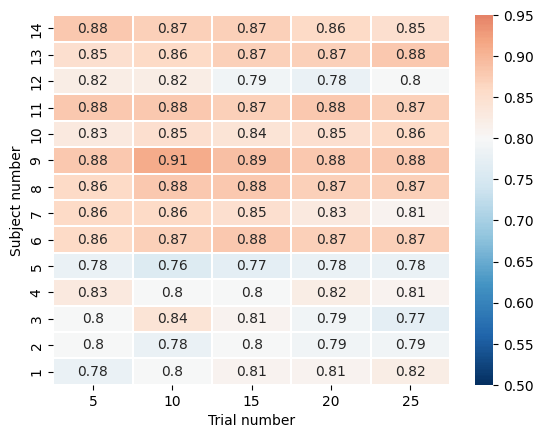

'/media/sun/TFcard/drop_landing_workspace/results/visualization/P6/Fig_results_augmentation_heatmap.svg'

In [7]:
# imu augmentation
combination_investigation_results = [ 
    os.path.join(RESULTS_PATH, "training_testing","augmentation_v11_5", str(train_sub_num)+"sub", str(trial_num)+"trials",
                 "testing_result_folders.txt") for train_sub_num in range(1,15,1) for trial_num in range(5,26,5)]

#metrics = get_list_investigation_metrics(combination_investigation_results)

combination_investigation_metrics = [os.path.join(os.path.dirname(folder),"metrics.csv") for folder in combination_investigation_results]
filters={'drop_value':0.0,'sort_variable':'r2'}


aug_metrics = parase_list_investigation_metrics(combination_investigation_metrics,**filters)
#aug_metrics['subject_num'].replace({idx:idx-4 for idx in range(5,11)},inplace=True)

data = aug_metrics[['trial_num','train_sub_num','r2']].groupby(['train_sub_num','trial_num']).mean().round(2).reset_index().pivot('train_sub_num','trial_num')['r2']
ax = sns.heatmap(data, vmin=0.5, vmax=0.95,cmap="RdBu_r",center=0.8,annot=True,linewidths=0.3).invert_yaxis()
plt.ylabel('Subject number')
plt.xlabel('Trial number')
save_format='svg'
fig_path = os.path.join(RESULTS_PATH, "visualization/P6/Fig_results_augmentation_heatmap.svg")
save_figure("",fig_path=fig_path,fig_format=save_format)

In [22]:

combination_investigation_results = [
    os.path.join(RESULTS_PATH, "training_testing","investigation_imu_augment_v2",str(trial_idx)+"trials",str(sub_idx)+"sub","testing_result_folders.txt") for sub_idx in range(1,15,1) for trial_idx in range(5,6,5)
]

#metrics = get_list_investigation_metrics(combination_investigation_results)

combination_investigation_metrics = [os.path.join(os.path.dirname(folder),"metrics.csv") for folder in combination_investigation_results]
filters={'drop_value':0.0,'sort_variable':'r2'}
#filters={}

aug_metrics = parase_list_investigation_metrics(combination_investigation_metrics,**filters)

/home/sun/drop_landing_workspace/results/training_testing/investigation_imu_augment_v2/5trials/1sub/metrics.csv
DROP R2 cases below :0.0
/home/sun/drop_landing_workspace/results/training_testing/investigation_imu_augment_v2/5trials/2sub/metrics.csv
DROP R2 cases below :0.0
/home/sun/drop_landing_workspace/results/training_testing/investigation_imu_augment_v2/5trials/3sub/metrics.csv
DROP R2 cases below :0.0
/home/sun/drop_landing_workspace/results/training_testing/investigation_imu_augment_v2/5trials/4sub/metrics.csv
DROP R2 cases below :0.0
/home/sun/drop_landing_workspace/results/training_testing/investigation_imu_augment_v2/5trials/5sub/metrics.csv
DROP R2 cases below :0.0
/home/sun/drop_landing_workspace/results/training_testing/investigation_imu_augment_v2/5trials/6sub/metrics.csv
DROP R2 cases below :0.0
/home/sun/drop_landing_workspace/results/training_testing/investigation_imu_augment_v2/5trials/7sub/metrics.csv
DROP R2 cases below :0.0
/home/sun/drop_landing_workspace/results/

In [27]:
aug_metrics[['test_subject','child_test_id','r2','subject_num']].groupby(['test_subject', 'subject_num']).mean().round(2).to_csv('ss.csv')

In [24]:
aug_metrics.head()

,Unnamed: 0,model_selection,alias_name,subject_num,trial_num,labels_name,r2,r_rmse,test_subject,parent_test_id,child_test_id,Test ID,Metrics ID,subjects,trials,execution_time,additional_imus
838,838,imu_augment,1sub_5trials_imu_augment_v1,1,5,R_KNEE_MOMENT_X,0.010,0.267,P_18_hezhonghai,test_153328,test_43,test_153328,test_153328_43,P_08_zhangboyuan,0,-100,NaN
359,359,imu_augment,1sub_5trials_imu_augment_v1,1,5,R_KNEE_MOMENT_X,0.013,0.279,P_15_liuzhaoyu,test_152828,test_21,test_152828,test_152828_21,P_10_dongxuan,0,-100,NaN
160,160,imu_augment,1sub_5trials_imu_augment_v1,1,5,R_KNEE_MOMENT_X,0.023,0.278,P_19_xiongyihui,test_153242,test_46,test_153242,test_153242_46,P_08_zhangboyuan,0,-100,NaN
983,983,imu_augment,1sub_5trials_imu_augment_v1,1,5,R_KNEE_MOMENT_X,0.030,0.286,P_23_wangjinhong,test_152944,test_63,test_152944,test_152944_63,P_08_zhangboyuan,0,-100,NaN
560,560,imu_augment,1sub_5trials_imu_augment_v1,1,5,R_KNEE_MOMENT_X,0.036,0.258,P_13_xulibang,test_153124,test_16,test_153124,test_153124_16,P_08_zhangboyuan,0,-100,NaN


In [23]:
# table

filters={'drop_value':0.0,'sort_variable':'r2'}
aug_metrics = parase_list_investigation_metrics(combination_investigation_metrics,**filters)
aug_metrics[['trial_num','subject_num','r2']][aug_metrics['trial_num'].isin([25])].groupby(['subject_num','trial_num']).describe().round(2)['r2'][['min','50%', '75%','max']].T

/home/sun/drop_landing_workspace/results/training_testing/investigation_imu_augment_v2/5trials/1sub/metrics.csv
DROP R2 cases below :0.0
/home/sun/drop_landing_workspace/results/training_testing/investigation_imu_augment_v2/5trials/2sub/metrics.csv
DROP R2 cases below :0.0
/home/sun/drop_landing_workspace/results/training_testing/investigation_imu_augment_v2/5trials/3sub/metrics.csv
DROP R2 cases below :0.0
/home/sun/drop_landing_workspace/results/training_testing/investigation_imu_augment_v2/5trials/4sub/metrics.csv
DROP R2 cases below :0.0
/home/sun/drop_landing_workspace/results/training_testing/investigation_imu_augment_v2/5trials/5sub/metrics.csv
DROP R2 cases below :0.0
/home/sun/drop_landing_workspace/results/training_testing/investigation_imu_augment_v2/5trials/6sub/metrics.csv
DROP R2 cases below :0.0
/home/sun/drop_landing_workspace/results/training_testing/investigation_imu_augment_v2/5trials/7sub/metrics.csv
DROP R2 cases below :0.0
/home/sun/drop_landing_workspace/results/

KeyError: 'r2'

## Comparsion

{'baseline': 'Baseline', 'finetuning': 'Fine-tuning', 'imu_augment': 'IMU augmentation', 'Normal_DANN': 'DANN', 'DANN': 'TDANN', 'Aug_DANN': 'ADANN', 'baseline_mlnn': 'Measured dataset', 'augmentation': 'Augmented dataset'}
/media/sun/TFcard/drop_landing_workspace/results/training_testing/baseline_mlnn_v11_5/1sub/5trials/metrics.csv
DROP R2 cases below :0.0
/media/sun/TFcard/drop_landing_workspace/results/training_testing/baseline_mlnn_v11_5/1sub/10trials/metrics.csv
DROP R2 cases below :0.0
/media/sun/TFcard/drop_landing_workspace/results/training_testing/baseline_mlnn_v11_5/1sub/15trials/metrics.csv
DROP R2 cases below :0.0
/media/sun/TFcard/drop_landing_workspace/results/training_testing/baseline_mlnn_v11_5/1sub/20trials/metrics.csv
DROP R2 cases below :0.0
/media/sun/TFcard/drop_landing_workspace/results/training_testing/baseline_mlnn_v11_5/1sub/25trials/metrics.csv
DROP R2 cases below :0.0
/media/sun/TFcard/drop_landing_workspace/results/training_testing/baseline_mlnn_v11_5/2sub/5

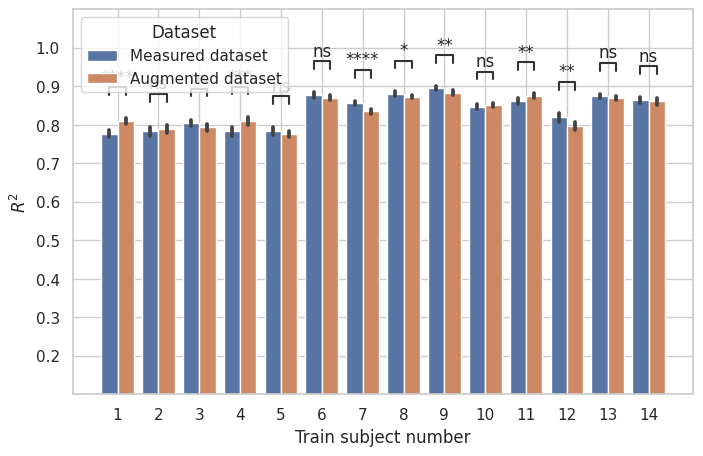

/media/sun/TFcard/drop_landing_workspace/results/visualization/P6/Fig_results_comparison_v2.svg


'/media/sun/TFcard/drop_landing_workspace/results/visualization/P6/Fig_results_comparison_v2.svg'

In [3]:
# compare baseline and imu augmentation
combination_investigation_results = [
    os.path.join(RESULTS_PATH, "training_testing","baseline_mlnn_v11_5",
                 str(train_sub_num)+"sub",str(trial_num)+"trials",
                 "testing_result_folders.txt") for train_sub_num in range(1,15,1) for trial_num in range(5,26,5)
                                    ]+ [
    os.path.join(RESULTS_PATH, "training_testing","augmentation_v11_5",
                 str(train_sub_num)+"sub",str(trial_num)+"trials",
                 "testing_result_folders.txt") for train_sub_num in range(1,15,1) for trial_num in range(5,26,5)
                                    ]

#metrics = get_list_investigation_metrics(combination_investigation_results)
combination_investigation_metrics = [os.path.join(os.path.dirname(folder),"metrics.csv") for folder in combination_investigation_results]

#subs = list(set(metrics['alias_name']))
#replace_values = {sub: int(sub.split('v')[1])-1 for sub in subs}
replace_values = {}
replace_values.update({'baseline': 'Baseline', 'finetuning': 'Fine-tuning', 'imu_augment': 'IMU augmentation', 'Normal_DANN': 'DANN', 'DANN': 'TDANN', 'Aug_DANN': 'ADANN'})
replace_values.update({'baseline_mlnn': 'Measured dataset', 'finetuning': 'Fine-tuning', 'augmentation': 'Augmented dataset', 'Normal_DANN': 'DANN', 'DANN': 'TDANN', 'Aug_DANN': 'ADANN'})
print(replace_values)
replace_columns = {'train_sub_num': 'Train subject number', 'trial_num': 'Trial number', 'model_selection':'Dataset'}
test_pairs =(
            [(1,'Measured dataset'), (1,'Augmented dataset')],
            [(2,'Measured dataset'), (2,'Augmented dataset')],
            [(3,'Measured dataset'), (3,'Augmented dataset')],
            [(4,'Measured dataset'), (4,'Augmented dataset')],
            [(5,'Measured dataset'), (5,'Augmented dataset')],
            [(6,'Measured dataset'), (6,'Augmented dataset')],
            [(7,'Measured dataset'), (7,'Augmented dataset')],
            [(8,'Measured dataset'), (8,'Augmented dataset')],
            [(9,'Measured dataset'), (9,'Augmented dataset')],
            [(10,'Measured dataset'), (10,'Augmented dataset')],
            [(11,'Measured dataset'), (11,'Augmented dataset')],
            [(12,'Measured dataset'), (12,'Augmented dataset')],
            [(13,'Measured dataset'), (13,'Augmented dataset')],
            [(14,'Measured dataset'), (14,'Augmented dataset')],
            )


plot_config={
        "save_fig": True, "save_format":"jpg", "save_folder_index": 0,
         'figsize':(8, 5),
         "hue": 'Dataset',
        'replace_values': replace_values,
        'replace_columns': replace_columns,
        'x': 'Train subject number',
        #'y': 'mean_subject_r2',
        'y': 'r2',
        'title': 'baseline',
        'yticks': (0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0),
        #'plot_title': 'baseline',
    'filters': {'drop_value':0.0,'sort_variable':'r2'},
    'font_scale': 1.0,
    'plot_type': 'barplot',
    'ttest':True,
    'fig_path': os.path.join(RESULTS_PATH, "visualization/P6/Fig_results_comparison_v2.svg"),
    'test_pairs':test_pairs
    }

filters={'drop_value':0.0,'sort_variable':'r2'}
p6plot_model_accuracy(combination_investigation_metrics, **plot_config)

Fig. Estimation accuracy ($R^2$) of the knee extension moment (KEM) under the different dataset type (measured raw dataset and its augmented dataset) and size (subject and trial numbers). 